### <font color='Green'>Project Objective: RAG-Enhanced LLM Pipeline for Querying JP Morgan Chase's Code of Conduct Policy
<hr style="border: 2px solid lightgray;">

###  <font color='blue'> Objective:
Design and implement an advanced system for efficient and context-aware resolution of HR policy queries, leveraging document retrieval and generation techniques to extract and synthesize relevant information from policy documents.<br>    
**NOTE:**
*The following code is executable on Google Colaboratory.*


#### <font color='purple'>**Step 1: Mount G-Drive**

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <font color='purple'>**Step 2: Installing necessary packages**

In [ ]:
# Install few additional packages
!pip install -U transformers
!pip install -U bitsandbytes accelerate
!pip install -U chromadb
!pip install -U langchain
!pip install -U langchain-community langchain-core
!pip install fitz
!pip install pymupdf
!pip install -U langchain-text-splitters
!pip install -U sentence-transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.0 MB/s eta 0:00:00
  

### <font color='purple'>**Step 3: Importing necessary libraries**

In [ ]:
# ---------------------------------------------------------------------------------------------
# IMPORTANT:  THE FOLLOWING SCRIPT USES RH3 (RR_ANALYST): SAP HANA DATABASE FOR QUERYING DATA
# ---------------------------------------------------------------------------------------------

# # Import packages
import re
import pandas as pd
import numpy as np
import time
script_start_time = time.time()

# Importing the necessary libraries
import numpy as np
import pandas as pd
# set max_rows option to None
pd.options.display.max_rows = None      # To display all the requested rows
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)
# Set the maximum width of each column to display
pd.set_option('display.max_colwidth', None)

import os
import concurrent.futures   # For parallel computing
import logging
logging.basicConfig(level=logging.INFO)
import urllib.request
import io
import os
import shutil
import concurrent.futures               # For Multi-Threading
import logging                          # For Logging info logs
logging.basicConfig(level=logging.INFO) # Set logging level
import numpy as np
import datetime
import pytz                             # For current datetime in IST zone
import os
import time
import numpy as np
import time
import glob
import random
random.seed(0)
np.random.seed(0)

import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import time
from datetime import date

import os
# os.getcwd()
os.environ['CURL_CA_BUNDLE'] = ''

import torch
import time
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
from IPython.display import Image, display

# For generating a vector store
import chromadb

### <font  color='purple'>**Step 4**:

#### <font  color='maroon'>**[EDIT VARIABLES]** *(if required)*

In [ ]:
# RAG FILES FOLDER PATH (EDIT IF REQUIRED)
rag_folder_path = "/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM"    # (EDIT IF REQUIRED)

# Image paths
rag_pipeline_image_path = os.path.join(rag_folder_path, "Temp_Images/rag_llm_pipeline_overview.PNG")
pymupdfreader_image_path = os.path.join(rag_folder_path, "Temp_Images/PDF_Reader_Performances.JPG")

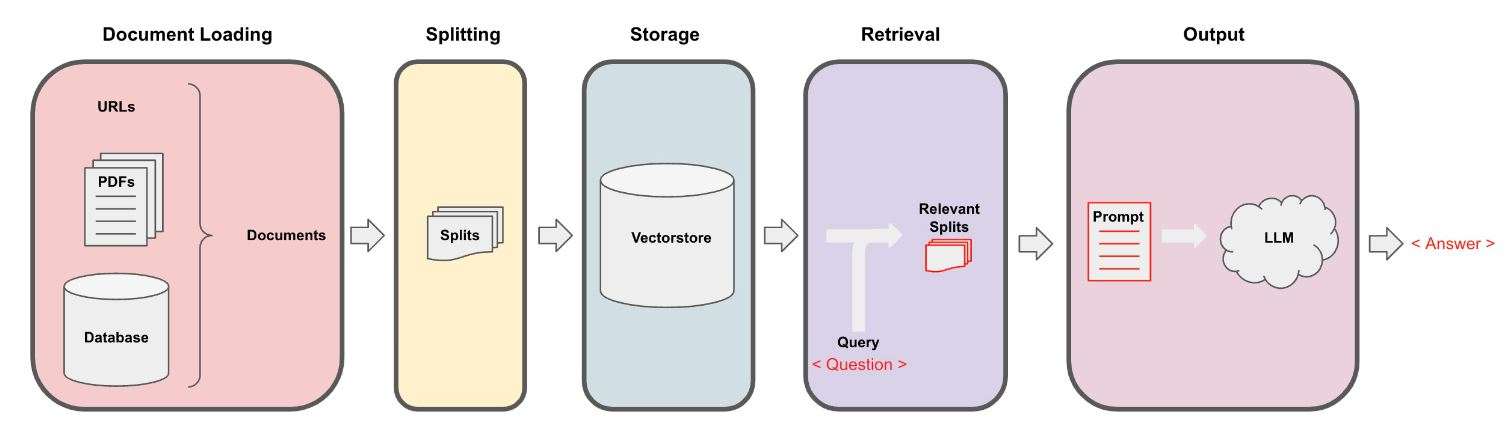

In [ ]:
# Display the RAG pipeline image
display(Image(filename=rag_pipeline_image_path))

### <font color='purple'>**Step 5: Steps incorporated in RAG + LLM Pipeline:**

**1. Document Loading** *(loading pdfs using `PyMuPDFLoader`)*<br>
**2. Document Splitting** *(Using Recursive Character Text Splitter)*<br>
**3. Storage** (Using embeddings model `'sentence-transformers_all-mpnet-base-v2'` to create embeddings of chunks and storing them in vectorstore. eg. `ChromaDB or FAISS`)<br>
**4. Retrieval**: Fetching Relevant Splits (top k chunks basis a search type like "similarity" or "mmr")<br>
**5. Combining Query + Dynamically Fetched Chunks** -> Fed to LLM (Mistral-7B-Instructv0.2 used here).<br>
**6. Response Output** (Generated Response To Query)<br>

### <font color='blue'>**[DATE FILE]**
For the purpose of analysis, we have used **J.P. Morgan Chase's Code of Conduct Policy Document** [web link - *(publicly available)*](https://www.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/code-of-conduct.pdf)

### <font color='purple'>**5.1. Document Loading** *(loading pdfs using `PyMuPDFLoader`)*

In [ ]:
# ## [FOR MULTIPLE DOCUMENT LOADING]
# from langchain.document_loaders import PyPDFLoader
# from langchain_community.document_loaders import PyMuPDFLoader

# # Step 1: Loading the PDF information documents
# loaders = [
#     # Duplicate documents on purpose - messy data
#     PyMuPDFLoader(os.path.join(rag_folder_path, "data_files/jp-morgan-chase-code-of-conduct-policy.pdf")),
#     PyMuPDFLoader(os.path.join(rag_folder_path, "data_files/jp-morgan-chase-code-of-conduct-policy.pdf")),
#     PyMuPDFLoader(os.path.join(rag_folder_path, "data_files/jp-morgan-chase-code-of-conduct-policy.pdf")),
# ]
# pages = []
# for loader in loaders:
#     pages.extend(loader.load())

# # # Step 1: Loading the PDF information documents

# # # ------------------------------------------------------------------
# # # From document loaders importing PyMuPDFLoader for loading the pdf
# # # [Experiments conducted (medium article): lesser Levenshtein Distance overall and good cosine similarity]
# # from langchain_community.document_loaders import PyMuPDFLoader

# # loader = PyMuPDFLoader(os.path.join(rag_folder_path, "data_files/jp-morgan-chase-code-of-conduct-policy.pdf"))

# # # Splitting into respective pages (in a list)
# # pages = loader.load()

In [ ]:
# Step 1: Loading the PDF information documents

# ------------------------------------------------------------------`
# From document loaders importing PyMuPDFLoader for loading the pdf
# [Experiments conducted (medium article): lesser Levenshtein Distance overall and good cosine similarity]

from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(os.path.join(rag_folder_path, "data_files/jp-morgan-chase-code-of-conduct-policy.pdf"))

# Splitting into respective pages (in a list)
pages = loader.load()

In [ ]:
print(pages[0])

page_content='Our Code 
of Conduct 
2024 
JPMorgan Chase 
' metadata={'source': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'file_path': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'page': 0, 'total_pages': 18, 'format': 'PDF 1.7', 'title': 'Our Code of Conduct 2024', 'author': 'JP Morgan Chase', 'subject': 'Code of Conduct', 'keywords': 'Our, Code, of, Conduct, 2024, JP, Morgan, Chase', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in with ClearScan', 'creationDate': "D:20240723161408-04'00'", 'modDate': "D:20240805105000-04'00'", 'trapped': ''}


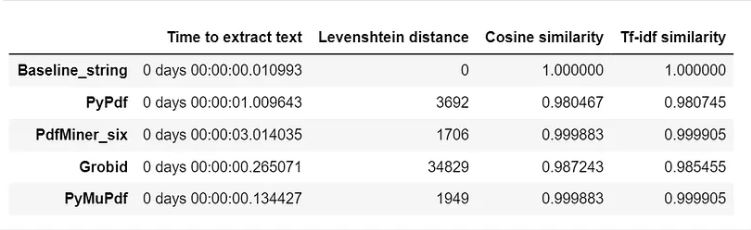

In [ ]:
# Display the pdf reader performance comparison image
display(Image(filename=pymupdfreader_image_path))

**Note:**<br>
1. `PyMuPdf` beats most of the benchmarks with least Levenshtein distance and highest cosine similarity with the original (baseline) string.
2. Although `PdfMiner_six` does a slightly better job than `PyMuPdf`, it is faster. Hence, using `PyMuPdf`.

**Note:**<br>
Each page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [ ]:
# Contains 'page_content' and 'meta_data' of respective documents
# Example of first 2 pages of a document
for page in  pages[:2]:
    print("*"*70)
    print(page)

**********************************************************************
page_content='Our Code 
of Conduct 
2024 
JPMorgan Chase 
' metadata={'source': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'file_path': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'page': 0, 'total_pages': 18, 'format': 'PDF 1.7', 'title': 'Our Code of Conduct 2024', 'author': 'JP Morgan Chase', 'subject': 'Code of Conduct', 'keywords': 'Our, Code, of, Conduct, 2024, JP, Morgan, Chase', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in with ClearScan', 'creationDate': "D:20240723161408-04'00'", 'modDate': "D:20240805105000-04'00'", 'trapped': ''}
**********************************************************************
page_content='Code of Conduct 
JPMorganChase is deeply committed to being honest in all of our business de

In [ ]:
# Count of pages in the document
len(pages)

18

In [ ]:
# Loading the content of page 1 (begins with index:0)
page = pages[0]

In [ ]:
# loading the first 500 characters of page_content (page 0 i.e. real page 1 content)
print(page.page_content[0:500])

Our Code 
of Conduct 
2024 
JPMorgan Chase 



In [ ]:
# Loading the metadata of the page 1 (with index 0)
# Contains: 'source file name' and the page number the 'page_content' belongs to (begins with 0)
page.metadata

{'source': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf',
 'file_path': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf',
 'page': 0,
 'total_pages': 18,
 'format': 'PDF 1.7',
 'title': 'Our Code of Conduct 2024',
 'author': 'JP Morgan Chase',
 'subject': 'Code of Conduct',
 'keywords': 'Our, Code, of, Conduct, 2024, JP, Morgan, Chase',
 'creator': 'Microsoft® PowerPoint® for Microsoft 365',
 'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in with ClearScan',
 'creationDate': "D:20240723161408-04'00'",
 'modDate': "D:20240805105000-04'00'",
 'trapped': ''}

### <font color='purple'> **5.2. Document Splitting** *(Using Recursive Character Text Splitter)*

In [ ]:
# Importing the necessary libraries for TextSplitting basis character (Using Recursive Character Text Splitter)

from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_text_splitters import RecursiveCharacterTextSplitter


# ===============================================================
# Defining params
# 1. chunk_size   : max no. of characters every chunk could have (NOTE: Considers the next ending whitespace character to avoid half word splits)
# 2. chunk_overlap: no. of characters overlap between successive chunks (to take care of context in-between chunks)
# 3. length_function: counting done basis
# ===============================================================

# # NOTE:
# The actual size of the chunks might be slightly larger than chunk_size due to the way the 'RecursiveCharacterTextSplitter' works.
# It splits the text at the closest whitespace character to the chunk_size boundary, which might be more than chunk_size characters away.

# ===============================================================
# Step 2: Using RecursiveCharacterTextSplitter to split documents
# ===============================================================

# Defining hyperparameters for RecursiveCharacterTextSplitter (EDIT IF REQUIRED)
CHUNK_SIZE = 1000
CHUNK_OVERLAP =  150 # (15% of CHUNK_SIZE)

from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CHUNK_SIZE,
    chunk_overlap = CHUNK_OVERLAP, # 20% of chunk_size
)

# **Note** *(Details of useful arguments):*<br>
# - `create_documents()`: Create documents from a list of texts.
# - `split_documents() `: Split documents.
# - `split_text()      `: Split incoming text and return chunks.

# Document splits
splits = text_splitter.split_documents(pages)


In [ ]:
# Count of split documents
len(splits)

47

In [ ]:
# First document in the split chunk
splits[0]

Document(metadata={'source': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'file_path': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf', 'page': 0, 'total_pages': 18, 'format': 'PDF 1.7', 'title': 'Our Code of Conduct 2024', 'author': 'JP Morgan Chase', 'subject': 'Code of Conduct', 'keywords': 'Our, Code, of, Conduct, 2024, JP, Morgan, Chase', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in with ClearScan', 'creationDate': "D:20240723161408-04'00'", 'modDate': "D:20240805105000-04'00'", 'trapped': ''}, page_content='Our Code \nof Conduct \n2024 \nJPMorgan Chase')

In [ ]:
pages[0].page_content

'Our Code \nof Conduct \n2024 \nJPMorgan Chase \n'

#### <font color='green'>*Checking split content*

In [ ]:
print("*"*100);print("EXAMINING CHUNK OVERLAP...");print("*"*100);print("\n\n")
# Split of pages (with chunk overlap)
for chunk_nos in range(0, 5):
  print(f"CHUNK NO.: {chunk_nos+1}");print("*"*15);print()
  print(splits[chunk_nos].page_content);print("*"*100);print("\n")

****************************************************************************************************
EXAMINING CHUNK OVERLAP...
****************************************************************************************************



CHUNK NO.: 1
***************

Our Code 
of Conduct 
2024 
JPMorgan Chase
****************************************************************************************************


CHUNK NO.: 2
***************

Code of Conduct 
JPMorganChase is deeply committed to being honest in all of our business dealings 
across the globe. 
The Code of Conduct represents our shared obligation to operate with the highest 
level of integrity and ethical conduct. We set high expectations and hold ourselves 
accountable. We do the right thing - not necessarily the easy or expedient thing. We 
abide by the letter and spirit of the laws and regulations everywhere we do business 
and have zero tolerance for unethical behavior. Personal accountability and 
ownership are priorities at

### <font color='purple'>**5.3. Storing Embeddings**

##### <font color='green'>**Storage** (Using embeddings model `'sentence-transformers_all-mpnet-base-v2'` to create embeddings of chunks and storing them in vectorstore. eg. `ChromaDB or FAISS`)

Let's take the splits (document splits) and embed them.

In [ ]:
# -----------------------------------------------------------------------
# DOWNLOADING SENTENCE-TRANSFORMER MODEL AND SAVING IT
# -----------------------------------------------------------------------
from sentence_transformers import SentenceTransformer
import os

# Load the model
embeddings_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Define directory to save the model
save_embeddings_model_directory = "/content/embeddings_model_files/sentence_transformers/sentence-transformers_all-mpnet-base-v2"

# Create the directory if it doesn't exist
os.makedirs(save_embeddings_model_directory, exist_ok=True)

# Save the model
embeddings_model.save(save_embeddings_model_directory)
print(f"Embeddings model saved to {save_embeddings_model_directory}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings model saved to /content/embeddings_model_files/sentence_transformers/sentence-transformers_all-mpnet-base-v2


In [ ]:
# For Loading HuggingFaceEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings

# Local Path of HuggingFaceEmbedding Model -> 'all-mpnet-base-v2'
LOCAL_EMBEDDINGS_FILE_PATH = "/content/embeddings_model_files/sentence_transformers/sentence-transformers_all-mpnet-base-v2"

# Loading the Embeddings Model
embedding = HuggingFaceEmbeddings(model_name=LOCAL_EMBEDDINGS_FILE_PATH)

<ipython-input-23-8da565ce2fae>:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name=LOCAL_EMBEDDINGS_FILE_PATH)


In [ ]:
print(splits[0].page_content)

Our Code 
of Conduct 
2024 
JPMorgan Chase


In [ ]:
print(splits[1].page_content)

Code of Conduct 
JPMorganChase is deeply committed to being honest in all of our business dealings 
across the globe. 
The Code of Conduct represents our shared obligation to operate with the highest 
level of integrity and ethical conduct. We set high expectations and hold ourselves 
accountable. We do the right thing - not necessarily the easy or expedient thing. We 
abide by the letter and spirit of the laws and regulations everywhere we do business 
and have zero tolerance for unethical behavior. Personal accountability and 
ownership are priorities at our firm. 
Our Code of Conduct and firm policies are designed to encourage exceptional 
business relationships, enabling us to continually build on our proud heritage. We 
must always act with integrity and be responsible for our actions, show respect for 
each other as well as those with whom we do business. 
To support our firm's purpose of making dreams possible for everyone, everywhere,


In [ ]:
# # # CHECKING --> SAMPLE COSINE-SIMILARITY BETWEEN ANY TWO SPLITS
# # ------------------------------------------------------------
# embedding1 = embedding.embed_query(splits[0].page_content)
# embedding2 = embedding.embed_query(splits[1].page_content)


# import numpy as np
# cos_sim = np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
# print(cos_sim)

#### <font color='blue'> Each of the embedding vector of `'sentence-transformers_all-mpnet-base-v2'` model would be a vector of size `768`.

#### <font color='purple'>**Storing this in ChromaDB (Vector Store)**

In [ ]:
import os
import shutil

# Directory to store parquet files (vectorstores in ChromaDB)
persist_directory = "/content/chroma_vector_db"

def reset_persist_directory(persist_directory):
    """
    Resets the specified persist directory by removing it if it exists and then creating a new empty directory.

    This function is used to ensure that the persist directory is clean and ready for storing new parquet files
    (vector stores in ChromaDB). It performs the following steps:

    1. Checks if the persist directory exists.
    2. If it exists, removes the directory and all its contents.
    3. Creates a new directory at the specified path.
    4. If the directory does not exist, it simply creates the directory.

    Args:
        persist_directory (str): The path of the directory to reset.

    Returns:
        None
    """
    # Checking if persist directory (for chromadb exists or not) -> Remove if it exists and
    if os.path.exists(persist_directory):
        # Remove the folder and its content at the mentioned persist directory path
        shutil.rmtree(persist_directory)
        # Create a new directory (persist directory)
        os.makedirs(persist_directory)
    else:
        # Create a new directory (persist directory)
        os.makedirs(persist_directory)

    return None

# Reset persist directory for chromadb (vector store of embeddings) -> Using custom pre-defined function
reset_persist_directory(persist_directory)

In [ ]:
# Importing ChromaDB to store embeddings vectors
from langchain.vectorstores import Chroma

# -------------------------------------------------------------------------------------------------------
# Loading vectors to ChromaDB (vector stores would contain splits fetched from documents)
vectordb = Chroma.from_documents(
    documents=splits,  # Passing split docs (obtained from recursive-character-text-spliter)
    embedding=embedding, # Passing respective HuggingFaceEmbeddings Model
    persist_directory=persist_directory # Persist directory to persist()
)

# Count would be equal to that of split documents
print(vectordb._collection.count())

47


#### <font color='green'>***Sample Question***

In [ ]:
# ### Similarity Search

# # question = "As per Reliance, is there any policy that allows exchanging gifts?"
# question = "Could you provide me the whistle blower phone number for reporting purposes?"
# # question = "As per the code of conduct policy document, is there any policy that elaborates on how personal relationships should be at workplace?"

##### <font color='purple'>**A. Similarity Search**

In [ ]:
# # Using 'similarity_search' to find the nearest (k=4) three neighbors
# # k=3 implies closest 3 docs fetched basis similarity_search

# # [MAY HAVE NON-DISTINCT CHUNKS]
# docs = vectordb.similarity_search(question,k=4)

In [ ]:
# # Docs delivered by similarity search (MAY HAVE SIMILAR ONES)
# for idx, doc in enumerate(docs):
#     print("Meta Data: ", doc.metadata);print()
#     print(doc)
#     if idx!=len(docs)-1:
#         print("\n\n\n")

In [ ]:
# # Docs delivered by similarity search (MAY HAVE SIMILAR ONES) - 'page_content' only
# for idx, doc in enumerate(docs):
#     print("*"*70)
#     print(doc.page_content)
#     print("*"*70)
#     if idx!=len(docs)-1:
#         print("\n\n\n")

In [ ]:
# ----------------------------------------------------------------------
# Rechecking if chromadb version is >= 0.4.x
# (FOR SUCH VERSIONS NO NEED TO MANUALLY PERSIST THE CHROMA VECTORDB)
# ----------------------------------------------------------------------


import importlib.metadata
from packaging import version

package_name = 'chromadb'
package_version = importlib.metadata.version(package_name)
print(f'{package_name} version: {package_version}');print()

if version.parse(package_version) >= version.parse('0.4.0'):
    # No need to persist the vectordb (automatically persists)
    print("WARNING: No need to manually persist the chroma vectordb. Automatically persisted for this version of chroma.")
    pass
else:
    # save the current state of the vector database to disk
    # persist: to retain it for further use
    print("WARNING: Manually persisted chroma vectordb.")
    vectordb.persist()

chromadb version: 0.5.18



**Note:**<br>This might be off or less accurate in some cases due to different embeddings used (depends on embeddings model).

**Note:**<br>Max Marginal Relevace (MMR) Search helps in separating the distinct chunks out of the fetched chunks.
- `fetch_k`: maximum number of chunks that the method should retrieve from the database during the search (default fetch_k: int = 20)
- `k`: most relevant results from the retrieved results ( (default fetch_k: int = 4)

##### <font color='red'>**B. MMR**
##### *(MMR is not giving great results here.)*

In [ ]:
# # Conducting an MMR (Maximum Marginal Relevance Search) from Chroma VectorDB
# # Using MMR (Max Marginal Relevance - MMR Search) - To eliminate most similar chunks

# docs_mmr = vectordb.max_marginal_relevance_search(question, k=4)

In [ ]:
# # Docs delivered by mmr search (MAY HAVE SIMILAR ONES)
# for idx, doc in enumerate(docs_mmr):
#     print("Meta Data: ", doc.metadata);print()
#     print(doc)
#     if idx!=len(docs)-1:
#         print("\n\n\n")

In [ ]:
# # Docs delivered by mmr search (MAY HAVE SIMILAR ONES) --> Fetching 'page_content' only
# for idx, doc in enumerate(docs_mmr):
#     print("*"*70)
#     print(doc)
#     print("*"*70)
#     if idx!=len(docs)-1:
#         print("\n\n\n")

In [ ]:
# # Documents fetched via MMR search technique
# docs_mmr

### <font color='blue'>**Using LLM (without specifying filter explicitly)**

#### <font color='green'> Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:

1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

#### <font color='blue'>**Loading a Locally Downloaded LLM (Mistral-7B-Instruct-v0.2)**

In [ ]:

# ==================================================================================
# -------------- STEPS TO LOAD A LOCALLY DOWNLOADED MODEL --------------------------
# ==================================================================================

# Check if GPU is available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("*" * 70)
print(f"Device: {device}")
print("*" * 70)

import gc
gc.collect()

import torch
if device=='cuda':
    torch.cuda.empty_cache()


# 4-bit quantization:
# Define Quantization Config (SAME DEFINED CONFIG USED WHILE DOWNLOADING THE ONLINE VERSION AND SAVING IT.)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# =================================================================================
# 3. Now when you’re offline, reload the saved files with PreTrainedModel.from_pretrained() from the specified directory:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer

# Filepath to LOAD LLM FROM
model_tokenizer_filepath = os.path.join(rag_folder_path, "Mistral-7B-v0.2-Model-Files")  # EDIT IF REQUIRED


# OFFLINE DOWNLOADS
if 'model_4bit' not in globals():
    model_4bit = AutoModelForCausalLM.from_pretrained(model_tokenizer_filepath,
                                                    device_map={"": device},
                                                    quantization_config=quantization_config)

if 'tokenizer' not in globals():
    tokenizer = AutoTokenizer.from_pretrained(model_tokenizer_filepath)

**********************************************************************
Device: cuda
**********************************************************************


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [ ]:
# Mistral-7B-Instruct-v0.2 model architecture (quantized model will be loaded)
model_4bit

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNo

In [ ]:
# LlamaTokenizerFast (used by the model)
tokenizer

LlamaTokenizerFast(name_or_path='/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/Mistral-7B-v0.2-Model-Files', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

#### <font color='green'>**Defining a function to instantiate a LLM pipeline basis selected prompts**

In [ ]:
from langchain import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain import PromptTemplate, LLMChain

# ========================================================================================================================

# ====================================================================================================
# ====================================================================================================
# ====================================================================================================

# Defining a function to instantiate a LLM pipeline basis selected prompts

def pipeline_instantiate(model_4bit, tokenizer, MAX_NEW_TOKENS):
    """
    This Python function, pipeline_instantiate, is designed to create and return a text generation pipeline instance.
    Let's break down the arguments and parameters:

    "text-generation":
        This is the type of pipeline. In this case, it's a text generation pipeline.

    model=model_4bit:
        This is the model that the pipeline will use. Here, the model_4bit is a pre-trained LLM (Mistral-7B-Instruct-v0.2 LLM).

    tokenizer=tokenizer:
        This is the tokenizer that the pipeline will use. It's the tokenizer belongs to the respective model_4bit  (pre-trained LLM)

    use_cache=True:
        This means that the pipeline will use a cache of store previously computed results. This will speed up the computation.

    trust_remote_code=True:
        This means that the pipeline will trust and execute remote code, which can be risky if the remote code is not secure.

    device_map={"": device}:
        This is a dictionary that maps pipeline components to devices. Here, all components are mapped to the device variable.

    max_new_tokens=MAX_NEW_TOKENS:
        This is the maximum number of new tokens that the model will generate.

    num_return_sequences=1:
        This means that the pipeline will return only one generated sequence.

    eos_token_id=tokenizer.eos_token_id:
        This is the ID of the end-of-sequence token.

    pad_token_id=tokenizer.eos_token_id:
        This is the ID of the padding token. Here, it's set to the same value as the end-of-sequence token, which is not a common practice.

    The function returns the instantiated pipeline, pipeline_inst.
    """
    pipeline_inst = pipeline(
            "text-generation",
            model=model_4bit,
            tokenizer=tokenizer,
            use_cache=True,
            trust_remote_code=True,
            device_map={"": device},
            max_new_tokens=MAX_NEW_TOKENS,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )
    return pipeline_inst

# LOADING LLM MODEL( VIA HUGGINGFACE PIPELINE)
# Initialize the LLM Model
llm = HuggingFacePipeline(pipeline=pipeline_instantiate(model_4bit=model_4bit,
                                                        tokenizer=tokenizer,
                                                        MAX_NEW_TOKENS=500))

<ipython-input-41-0c7eb4e4aa52>:66: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipeline_instantiate(model_4bit=model_4bit,


In [ ]:
# Checking composition of metadata dictionary
pages[0].metadata

{'source': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf',
 'file_path': '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/data_files/jp-morgan-chase-code-of-conduct-policy.pdf',
 'page': 0,
 'total_pages': 18,
 'format': 'PDF 1.7',
 'title': 'Our Code of Conduct 2024',
 'author': 'JP Morgan Chase',
 'subject': 'Code of Conduct',
 'keywords': 'Our, Code, of, Conduct, 2024, JP, Morgan, Chase',
 'creator': 'Microsoft® PowerPoint® for Microsoft 365',
 'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in with ClearScan',
 'creationDate': "D:20240723161408-04'00'",
 'modDate': "D:20240805105000-04'00'",
 'trapped': ''}

### <font color='purple'>**Step 5.4 & 5.5:**

#### <font color='purple'>**Retrieval**: Fetching relevant splits *(top k chunks basis a search type like "similarity" or "mmr")*
#### <font color='purple'>**Combining Query + Dynamically Fetched Chunks** -> Fed to LLM *(Mistral-7B-Instructv0.2 used here)*<br><br>

#### <font color='green'> **Defining a function for querying using RAG pipeline** *(full length response)*



In [ ]:
# =============================================================================
# 1. Defining Attribute Info of the document
# =============================================================================

# Provide necessary metadata (keep it as descriptive as possible)
from langchain.chains.query_constructor.base import AttributeInfo

metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The excerpt is a chunk from the HR (Human Resources) Policy Document of a giant financial services company, JPMorgan Chase & Co",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page index from the policy document",
        type="integer",
    ),
]

# =============================================================================
# 2. Defining CONTEXT
# =============================================================================
context = '''Human Resource (HR) Policies on Code of Conduct. Remember page numbers as well.'''


# =============================================================================
# 3. Building prompt temlate for Question-Answering Chain
# =============================================================================
from langchain.prompts import PromptTemplate
template = '''[INST] Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know.
Don't try to make up an answer. Avoid Repetition of same pointers.

Context: {context}

Question: {question}
Helpful Answer: [/INST]'''

QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],
                                 template=template,
                                 template_format="f-string",)




# =============================================================================
# 4. Define a function that returns an answer to the query (full length answer)
# =============================================================================

# Defining a function to return query answer given the following inputs
# Inputs include
# (a.) query                                    -> 'question',
# (b.) LLM pipeline/model                       ->'llm',
# (c.) Vector Store DB                          -> 'vectordb',
# (d.) Attribute Info                           -> 'metadata_field_info',
# (e.) Question-Answering Chain Prompt Template -> 'QA_CHAIN_PROMPT'
# (f.) Search Type (mmr / similarity search)    -> 'SEARCH_TYPE'

from langchain.chains import RetrievalQA
def return_query_answer(question, llm, vectordb, metadata_field_info, QA_CHAIN_PROMPT, SEARCH_TYPE):

    # Initializing retriever
    retriever = vectordb.as_retriever(search_type=SEARCH_TYPE,
                                       metadata_field_info=metadata_field_info,
                                      search_kwargs={"k": 6})  # k: top chunks/splits to fetch to feed to the LLM

    # Run chain
    qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                           retriever=retriever,
                                           return_source_documents=True,
                                           chain_type='stuff', # DEFAULTS TO 'STUFF': All documents are scanned
                                           chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})

    # Final result after running chain -> RetrievalQA
    result = qa_chain.invoke({"query": question})
    # Final answer to the query
    answer = result["result"].split("[/INST]")[1].strip()
    # Return final answer to the query
    return answer

### <font color='blue'>(a.) Using Chroma + Maximal Marginal Relevance (MMR)

- The `Maximal Marginal Relevance (MMR)` criterion strives to reduce redundancy while maintaining query relevance in re- ranking retrieved documents and in selecting appropriate passages for text summarization.
-  `MMR` helps avoid redundant information

In [ ]:
# # =====================================================================================
# # # Maximal Marginal Relevance (MMR) Search
# # =====================================================================================

# # =====================================================================================
# # Related questions (IN CONTEXT)
# question_1 = "Are existing employees allowed to engage in corporate opportunities outside RJIL?"
# question_2 = "What does the section 7.3 of the policy document advise?"
# question_3 = "Could you provide me the whistle blower phone number for reporting purposes?"
# question_4 = "Can you tell me on which 'page number' of the document the whistleblower telephone number is located?"
# question_5 = "As per the code of conduct policy document, is there any policy that elaborates on how personal relationships should be at workplace?"
# question_6 = "Can you highlight or summarize the responsibilities of managers?"
# question_7 = "Can you highlight or summarize the responsibilities of directors?"
# question_8 = "Are employees allowed to engage in insider dealing?"
# question_9 = "Are the there any policies pertaining to any issues that Reliance has zero tolerance for?"
# question_10 = "What are the policies pertaining to any issues that Reliance has zero tolerance for?"
# question_11 = "Which policy or pointers talk about speaking up at workplace?"
# question_12 = "As per Reliance, is there any policy that allows exchanging gifts?"

# # Unrelated questions (OUT OF CONTEXT)
# question_13 = "Who is the President of India?"
# question_14 = "Could you tell me what does the document say about Machine Learning?"
# question_15 = "Who is Beyonce?"
# question_16 = "Why is the earth round?"


# # List of questions
# questions_l = [question_1, question_2, question_3, question_4,\
#                question_5, question_6, question_7, question_8,\
#                question_9, question_10, question_11, question_12,
#                question_13, question_14, question_15, question_16]


# # Declare SEARCH_TYPE
# SEARCH_TYPE='mmr'

# # ----------------------------------------
# # DELETE THIS LATER
# print("="*70)
# print(f"Context       : {context}");print()
# print(f"VectorDB Used : ChromaDB")
# print(f"Search Type   : {SEARCH_TYPE} [Maximal Marginal Relevance (MMR)]")
# print("="*70);print("\n\n")
# # ----------------------------------------


# # Fetching answers for multiple questions / queries
# for idx, question in enumerate(questions_l):
#     # Fetching answer to question (query)
#     answer = return_query_answer(question=question,
#                                  llm=llm,
#                                  vectordb=vectordb,
#                                  metadata_field_info=metadata_field_info,
#                                  QA_CHAIN_PROMPT=QA_CHAIN_PROMPT,
#                                  SEARCH_TYPE=SEARCH_TYPE)
#     print("*"*70)
#     print(f"Question: {idx+1}\n{question}\n")
#     print(f"Answer:\n{answer}")
#     print("*"*70);print("\n\n")

### <font color='red'> ChromaDB + MMR fails to deliver optimal performance.

### <font color='blue'>(b.) **Using ChromaDB + Similarity Search**

- Vector similarity search (or similarity search for embeddings) finds the “top K” most similar vectors to a query vector in a vector database.

### <font color='purple'>**5.6. Response Output** *(Generating Response To Queries using RAG pipeline)*

#### <font color='green'>**[Model Inferencing]**

In [ ]:
# To suppress unnecessary logs
import logging

# Set logging level to suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

import warnings

# Suppress specific warning messages
warnings.filterwarnings("ignore", message="You seem to be using the pipelines sequentially on GPU")

# ------------------------------------------------------------------------------------------------------
# CREATE DATASET OF QUERIES / QUESTION
from datasets import Dataset

# Define your questions here (EDIT IF REQUIRED)
questions_l = [
    "What kind of assistance can you provide based on the code of conduct?",
    "Can you provide the contact information or hotline to report violations or concerns to the relevant department?",
    "Which department is responsible for addressing employee concerns at JP Morgan Chase?",
    "What is the process for reporting a potential violation or concern at JP Morgan Chase?",
    "What are the responsibilities and duties of a manager at JP Morgan Chase according to the code of conduct?",
    "What are the ethics guidelines for employees at JP Morgan Chase?",
    "What should employees do if they witness illegal activity within the company?",
    "Does JP Morgan Chase have a non-retaliation policy, and if so, what does it entail?",
    "Are employees allowed to exchange gifts with external individuals with whom they have a professional relationship, but who are not employed by JP Morgan Chase?",
    "What guidelines or policies govern how employees are expected to manage information within the organization?",
    "Does JP Morgan Chase prioritize diversity and inclusion in its hiring practices?",
    "What types of communication are considered acceptable within the workplace and externally for employees?",
    "Is it appropriate to discuss personal finances in the workplace according to the code of conduct?",
    "Are employees allowed to engage in insider dealing?",
    "Are there any policies pertaining to any issues that JP Morgan Chase has zero tolerance for?",
    "What are the policies pertaining to any issues that JP Morgan Chase has zero tolerance for?",
    "Which policy or pointers talk about speaking up at workplace?",
    "Who is the President of India?",
    "Could you tell me what the document says about Machine Learning?",
    "Who is Beyonce?",
    "Why is the earth round?",
]


# Convert list of questions to a list of dictionaries with "query" and "query_id" keys
queries = [{"query_id": f"question_{i+1}", "query": q} for i, q in enumerate(questions_l)]

# Create a Hugging Face Dataset (USE THIS DATASET GOING FORWARD)
queries_dataset = Dataset.from_list(queries)

# ------- FOR DISPLAYING THE DATASET ONLY -------------------
# Convert to DataFrame and display
queries_df = queries_dataset.to_pandas()
queries_df

,query_id,query
0,question_1,What kind of assistance can you provide based on the code of conduct?
1,question_2,Can you provide the contact information or hotline to report violations or concerns to the relevant department?
2,question_3,Which department is responsible for addressing employee concerns at JP Morgan Chase?
3,question_4,What is the process for reporting a potential violation or concern at JP Morgan Chase?
4,question_5,What are the responsibilities and duties of a manager at JP Morgan Chase according to the code of conduct?
5,question_6,What are the ethics guidelines for employees at JP Morgan Chase?
6,question_7,What should employees do if they witness illegal activity within the company?
7,question_8,"Does JP Morgan Chase have a non-retaliation policy, and if so, what does it entail?"
8,question_9,"Are employees allowed to exchange gifts with external individuals with whom they have a professional relationship, but who are not employed by JP Morgan Chase?"
9,question_10,What guidelines or policies govern how employees are expected to manage information within the organization?


In [ ]:
import time
import textwrap # For displaying the output in proper format (Google Colaboratory)

a = time.time()

# Queries and answers filepath
queries_n_answers_filepath = os.path.join(rag_folder_path, 'output_files/query_n_answers_output.txt')

# Open a text file in write mode to store the output
try:
    with open(queries_n_answers_filepath, 'w') as file:
        # =====================================================================================
        # # SIMILARITY SEARCH
        # =====================================================================================

        # Define SEARCH_TYPE
        SEARCH_TYPE = 'similarity'

        # ----------------------------------------
        # Writing this to the output file
        file.write("=" * 125 + "\n")
        file.write(f"VectorDB Used : ChromaDB\n")
        file.write(f"Search Type   : {SEARCH_TYPE} [Similarity Search]\n")
        file.write("=" * 125 + "\n")

        print("=" * 125)
        print("VectorDB Used : ChromaDB")
        print(f"Search Type   : {SEARCH_TYPE} [Similarity Search]")
        print("=" * 125);print("\n\n")

        # ----------------------------------------

        # Storing responses in a list

        try:
            del response
        except NameError:
            pass

        response = []

        # Check if queries_dataset is not empty
        if not queries_dataset:
            print("Error: queries_dataset is empty.")
        else:
            # Fetch answers for each question in the dataset
            for entry in queries_dataset:
                question_id = entry.get("query_id", "")
                question = entry.get("query", "")

                if not question_id or not question:
                    print(f"Error: Missing data for entry {entry}")
                    continue  # Skip this entry if missing necessary data

                try:
                    # Fetching answer to the question
                    answer = return_query_answer(
                        question=question,
                        llm=llm,
                        vectordb=vectordb,
                        metadata_field_info=metadata_field_info,
                        QA_CHAIN_PROMPT=QA_CHAIN_PROMPT,
                        SEARCH_TYPE=SEARCH_TYPE
                    )

                    # Write question and answer to the file
                    file.write("*" * 125 + "\n")
                    question_id_str = " ".join(["Question", question_id.split("_")[-1]])
                    file.write(textwrap.fill(f"{question_id_str}: {question}", width=125) + "\n")
                    file.write("\n")
                    file.write(textwrap.fill(f"Answer:\n{answer}", width=125) + "\n")
                    response.append(answer)
                    file.write("*" * 125 + "\n")
                    file.write("\n\n")

                    # Print question and answer
                    print("*" * 125)
                    print(textwrap.fill(f"{question_id_str}: {question}", width=125))  # textwrap specific to Google Colaboratory (to display outputs)
                    print()
                    print(textwrap.fill(f"Answer:\n{answer}", width=125))             # textwrap specific to Google Colaboratory  (to display outputs)
                    # response.append(answer)
                    print("*" * 125)
                    print("\n\n")

                except Exception as e:
                    print(f"Error processing question {question_id}: {e}")

except Exception as e:
    print(f"Error while writing to file: {e}")


b = time.time()
time_req = round((b-a) / 60, 3)
print("*" * 125)
print(f"Time taken for querying using RAG pipeline: {time_req} minutes.")
print(f"Count of responses generated              : {len(response)}")
print("*" * 125)


VectorDB Used : ChromaDB
Search Type   : similarity [Similarity Search]



*****************************************************************************************************************************
Question 1: What kind of assistance can you provide based on the code of conduct?

Answer: Based on the code of conduct provided, I can offer interpretative guidance on the principles in the Code, in
consultation with relevant departments such as LOB Compliance, the Chief Compliance Officer, or the General Counsel. I can
also report any concerns or violations of the Code or firm policies to the appropriate parties and cooperate with any
investigation or inquiry. Additionally, I can provide information on reporting discrimination or harassment and the firm's
expectations for consultants, agents, contract or temporary workers in relation to the Code of Conduct.
*****************************************************************************************************************************



**

#### <font color='purple'>**Storing responses to the queries in dataset (under *response*).**

In [ ]:
# Storing the responses to the queries in the 'queries_df' dataframe
queries_df['response'] = pd.Series(response)
queries_df

,query_id,query,response
0,question_1,What kind of assistance can you provide based on the code of conduct?,"Based on the code of conduct provided, I can offer interpretative guidance on the principles in the Code, in consultation with relevant departments such as LOB Compliance, the Chief Compliance Officer, or the General Counsel. I can also report any concerns or violations of the Code or firm policies to the appropriate parties and cooperate with any investigation or inquiry. Additionally, I can provide information on reporting discrimination or harassment and the firm's expectations for consultants, agents, contract or temporary workers in relation to the Code of Conduct."
1,question_2,Can you provide the contact information or hotline to report violations or concerns to the relevant department?,"Yes, you can report violations or concerns to the JPMorganChase Conduct Hotline in three ways:\n\n1. Phone: 1-855-JPMCODE (1-855-576-2633) for U.S. and Canada, or use the provided link for all other locations.\n2. Online: Submit a report through the website at www.tnwgrc.com/jpmc.\n3. Mobile: Scan the provided code to submit a report through the mobile app.\n\nAdditionally, for concerns specifically related to accounting, internal controls, auditing matters, or financial reporting practices, you can contact the JPMorganChase Conduct Hotline or the Office of the General Counsel of JPMorgan Chase & Co. at 383 Madison Avenue, New York, NY 10179."
2,question_3,Which department is responsible for addressing employee concerns at JP Morgan Chase?,Code of Conduct Compliance is responsible for addressing employee concerns at JP Morgan Chase.
3,question_4,What is the process for reporting a potential violation or concern at JP Morgan Chase?,"The process for reporting a potential violation or concern at JP Morgan Chase involves several options. You can raise issues with your manager, Compliance Officer, Global Security, or Human Resources. Alternatively, you can call the JPMorganChase Conduct Hotline toll-free at 1-855-JPMCODE (1-855-576-2633) or file a report online at www.tnwgrc.com/jpmc. Reporting can be done anonymously, where permitted by law. If the concern is related to accounting, internal controls, auditing matters, or financial reporting practices, contact the JPMorganChase Conduct Hotline or the Office of the General Counsel of JPMorgan Chase & Co. at 383 Madison Avenue, New York, NY 10179. JPMorganChase strictly prohibits intimidation or retaliation against anyone who reports a potential or actual violation in good faith or assists with an investigation or inquiry."
4,question_5,What are the responsibilities and duties of a manager at JP Morgan Chase according to the code of conduct?,"According to the JP Morgan Chase Code of Conduct, managers are expected to set the ""tone from the top"" and remind employees of the importance of maintaining personal integrity and adhering to the firm's high ethical standards. Managers are also responsible for fostering a diverse and inclusive work environment, encouraging exceptional business relationships, and ensuring that all employees are aware of and comply with the firm's laws and regulations. Additionally, managers are expected to provide first-class service in a first-class way and encourage others to deal fairly with clients and suppliers. Managers are also responsible for reporting any violations they know about and ensuring that the firm's resources are used responsibly."
5,question_6,What are the ethics guidelines for employees at JP Morgan Chase?,"The ethics guidelines for employees at JP Morgan Chase include conducting themselves with honesty and integrity, treating customers and suppliers fairly, exercising sound judgment, maintaining personal accountability and ownership, and adhering to the firm's culture of respect and inclusivity. Employees are expected to comply with the law and firm policies, and always act appropriately when representing the firm, both inside and outside of

#### <font color='blue'>**NOTE:** Observe the differences in responses for the following set of queries categorized as in-context and out-of-context queries.

##### <font color='green'>**(IN-CONTEXT QUERIES)**: From Question 1 to Question 17

##### <font color='maroon'>**(OUT-OF-CONTEXT QUERIES)**: From Question 18 to Question 21


In [ ]:
# Saving the dataframe containing queries and their responses to a file
queries_n_response_filepath = os.path.join(rag_folder_path, "output_files/Queries_and_Responses.csv")
queries_df.to_csv(queries_n_response_filepath, index=False)

print("*"*125)
print(f"Queries and Responses file saved at '{queries_n_response_filepath}'")
print("*"*125)
print(f"Count of query and answer pairs in the output file: {pd.read_csv(queries_n_response_filepath).shape[0]}")
print("*"*125)
print("*"*125)

*****************************************************************************************************************************
Queries and Responses file saved at '/content/drive/MyDrive/W_Content/RAG_Routine/RAG+LLM/output_files/Queries_and_Responses.csv'
*****************************************************************************************************************************
Count of query and answer pairs in the output file: 21
*****************************************************************************************************************************
*****************************************************************************************************************************
